In [1]:
from paraphraser import Paraphraser
paraphraser = Paraphraser()
original_sentence = "heute regnet es schon wieder genau wie gestern und vorgestern ich muss also die Strassenbahn nehmen."
paraphrased_sentence = paraphraser.paraphrase(original_sentence)
print(f"Paraphrased: {paraphrased_sentence}")

Paraphrased: heute regnet es wieder wie gestern und vorgestern ich nehme also die strassenbahn|heute ist es wieder nass genau wie gestern und vorgestern ich muss also die strassenbahn benutzen|es regnet heute schon wieder genauso wie gestern und vorgestern also nehme ich die strassenbahn|heute gibt es erneut regen wie an den tagen zuvor ich muss also die strassenbahn nehmen|es regnete heute wieder so wie an den beiden vorangegangenen tagen ich muss somit die strassenbahn nehmen|heute ist es schon wieder regnerisch wie gestern und vorgestern daher nehme ich die strassenbahn


In [2]:
from data import Text

In [3]:
gt = Text("01_eval_gt.txt")

In [4]:
pred_gladia = Text("01_eval_gladia.txt")
pred_msft = Text("01_eval_msft.txt")

In [5]:
pred_gladia.sentences[:5]

['Da', 'Das war ja nicht so', 'dass du mich mailst', 'Ja', 'aber keine Ahnung']

In [6]:
gt.sentences[:5]

['Es war etwas schwierig mit dem Email',
 'Ich weiss auch nicht ich habe es wieder gelöscht und geschaut aber nichts gefunden',
 'Wir haben es ja noch geschafft',
 'Genau',
 'konnten Sie es schon auswerten']

In [7]:
import re
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

def normalize_texts(text_list):
    normalized_texts = []
    for text in text_list:
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = text.replace('ß', 'ss')
        tokens = word_tokenize(text, language='german')
        normalized_texts.append(' '.join(tokens))
    return normalized_texts

# Normalize predictions and ground truth
normalized_predictions_gladia = normalize_texts(pred_gladia.sentences)
normalized_pred_msft = normalize_texts(pred_msft.sentences)
normalized_ground_truth = normalize_texts(gt.sentences)

[nltk_data] Downloading package punkt_tab to /home/kenfus/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
word_tokenize("Test 123, das ist ein Test.", language='german')

['Test', '123', ',', 'das', 'ist', 'ein', 'Test', '.']

In [9]:
from evaluate import load
sacre_bleu = load("sacrebleu")
wer = load("wer")

/home/kenfus/miniconda3/envs/paraboth/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
concat_norm_pred_gladia = ' '.join(normalized_predictions_gladia)
concat_norm_gt = ' '.join(normalized_ground_truth)
concat_norm_pred_msft = ' '.join(normalized_pred_msft)

print("GLADIA:")
print("BLEU:", sacre_bleu.compute(predictions=[concat_norm_pred_gladia], references=[concat_norm_gt]))
print("WER:", wer.compute(predictions=[concat_norm_pred_gladia], references=[concat_norm_gt] ))

print("MSFT:")
print("BLEU:", sacre_bleu.compute(predictions=[concat_norm_pred_msft], references=[concat_norm_gt]))
print("WER:", wer.compute(predictions=[concat_norm_pred_msft], references=[concat_norm_gt] ))

GLADIA:
BLEU: {'score': 25.460492687450763, 'counts': [803, 403, 218, 131], 'totals': [1030, 1029, 1028, 1027], 'precisions': [77.96116504854369, 39.1642371234208, 21.20622568093385, 12.755598831548198], 'bp': 0.8445662991453214, 'sys_len': 1030, 'ref_len': 1204}
WER: 0.6121262458471761
MSFT:
BLEU: {'score': 37.26798870809672, 'counts': [865, 535, 357, 264], 'totals': [993, 992, 991, 990], 'precisions': [87.10976837865056, 53.931451612903224, 36.02421796165489, 26.666666666666668], 'bp': 0.8085704946372312, 'sys_len': 993, 'ref_len': 1204}
WER: 0.4676079734219269


In [28]:
def create_sentence_combinations(texts, window_size=2):
    combined_texts = []
    
    for i in range(len(texts)):
        # Forward combinations
        for j in range(1, window_size+1):
            if i + j <= len(texts):
                combined_text = ' '.join(texts[i:i+j])
                combined_texts.append(combined_text)
                
        # Backward combinations
        for j in range(1, window_size+1):
            if i - j >= 0:
                combined_text = ' '.join(texts[i-j:i+1])
                combined_texts.append(combined_text)
    
    return combined_texts


In [29]:
combined_pred_gladia = create_sentence_combinations(normalized_predictions_gladia)
combined_pred_msft = create_sentence_combinations(normalized_pred_msft)
combined_gt = create_sentence_combinations(normalized_ground_truth)

In [11]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize the model
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Compute embeddings
pred_embeddings = model.encode(normalized_predictions_gladia)
gt_embeddings = model.encode(normalized_ground_truth)
pred_embeddings_msft = model.encode(normalized_pred_msft)

# Compute similarity matrix
similarity_matrix = cosine_similarity(pred_embeddings, gt_embeddings)
similarity_matrix_msft = cosine_similarity(pred_embeddings_msft, gt_embeddings)

/home/kenfus/miniconda3/envs/paraboth/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
normalized_ground_truth[:5]

['es war etwas schwierig mit dem email',
 'ich weiss auch nicht ich habe es wieder gelöscht und geschaut aber nichts gefunden',
 'wir haben es ja noch geschafft',
 'genau',
 'konnten sie es schon auswerten']

In [13]:
from dtwsa import SentenceAligner
aligner = SentenceAligner(similarity_matrix=similarity_matrix, min_matching_value=0.5)

In [14]:
alignment, score = aligner.align_sentences(normalized_predictions_gladia, normalized_ground_truth)

In [15]:
print("Sentence Similarity Score: ", score / len(alignment))

Sentence Similarity Score:  0.8007113276841398


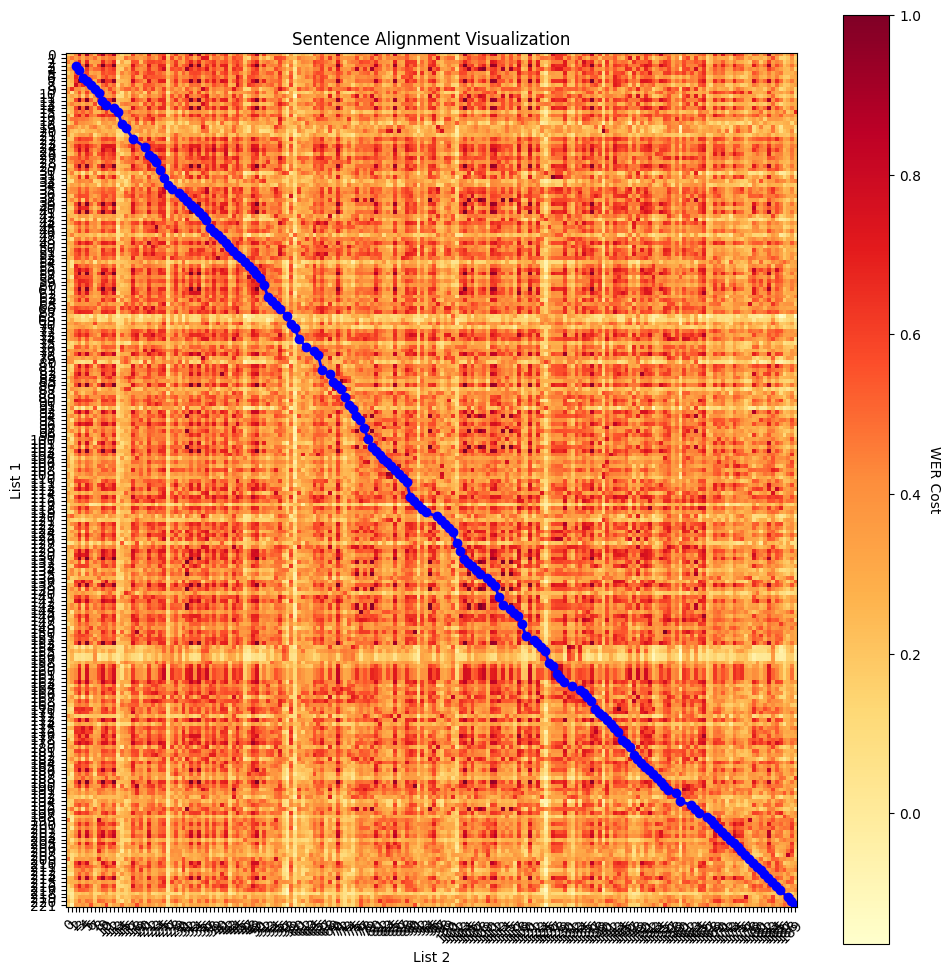

In [16]:
aligner.visualize_alignment(normalized_predictions_gladia, normalized_ground_truth, show_sentences_as_labels=False, add_sim_value=False, fig_size=(10, 10))

In [17]:
def return_alignment_as_sentences(list1, list2, alignment):
    aligned_list = []
    for i, j in alignment:
        aligned_list.append((list1[i], list2[j]))
    return aligned_list


In [18]:
alinged_gladia = return_alignment_as_sentences(normalized_predictions_gladia, normalized_ground_truth, alignment)

In [19]:
from dtwsa import SentenceAligner
aligner = SentenceAligner(similarity_matrix=similarity_matrix_msft, min_matching_value=0.5)

In [20]:
alignment, score = aligner.align_sentences(normalized_pred_msft, normalized_ground_truth)

In [21]:
print("Sentence Similarity Score: ", score / len(alignment))

Sentence Similarity Score:  0.8284170696996662


In [22]:
alinged_gladia[10:15]

[('die phase war so', 'phasenweise so ups and downs gehabt'),
 ('und ich habe sofort eine gute phase gehabt',
  'ich hatte das gefühl nach unserem treffen hatte ich ein paar tage eine gute phase gehabt'),
 ('und dann ist es einfach wieder nicht so gut gegangen',
  'eine woche vielleicht und dann ist es wieder nicht so gut gegangen'),
 ('was das für eine auslösung für alle die damen ist', 'es ist je nachdem'),
 ('hat man später erfahren',
  'letztes mal nach unserem treffen habe ich nach ein paar wochen erfahren')]

In [23]:
alinged_msft = return_alignment_as_sentences(normalized_pred_msft, normalized_ground_truth, alignment)

In [24]:
alinged_msft[10:16]

[('ich muss jetzt noch die auslösen', 'es ist je nachdem'),
 ('vor allem', 'was sind denn so die auslöser vor allem bei den downs'),
 ('letztes mal nach unserem treffen habe ich eine woche später erfahren',
  'letztes mal nach unserem treffen habe ich nach ein paar wochen erfahren'),
 ('dass', 'dass der lukas'),
 ('mit dem ich', 'mit dem ich ein bisschen eine beziehung gehabt habe'),
 ('und zwar mit einer anderen frau',
  'dass er mit jemanden in die ferien ist und zwar mit einer anderen frau')]

In [25]:
paraphraser = Paraphraser()

In [26]:
paraphrased_gt = paraphraser.paraphrase_list(normalized_ground_truth)

100%|██████████| 190/190 [01:42<00:00,  1.85it/s]


In [27]:
paraphrased_gladia = paraphraser.paraphrase_list(normalized_predictions_gladia)

In [26]:
paraphrased_msft = paraphraser.paraphrase_list(normalized_pred_msft)

  5%|▌         | 10/183 [00:03<01:05,  2.66it/s]

In [ ]:
paraphrased_gt

In [ ]:
# New metrics to evaluate final goal.
# Make transcription worse / better.
# Easy to use pipeline. 
# Match unmatched GT with empty string.

In [ ]:
print("GLADIA:")
print("BLEU:", sacre_bleu.compute(predictions=[concat_norm_pred_gladia], references=[paraphrased_gt]))
print("WER:", wer.compute(predictions=[concat_norm_pred_gladia], references=[concat_norm_gt] ))

print("MSFT:")
print("BLEU:", sacre_bleu.compute(predictions=[concat_norm_pred_msft], references=[concat_norm_gt]))
print("WER:", wer.compute(predictions=[concat_norm_pred_msft], references=[concat_norm_gt] ))

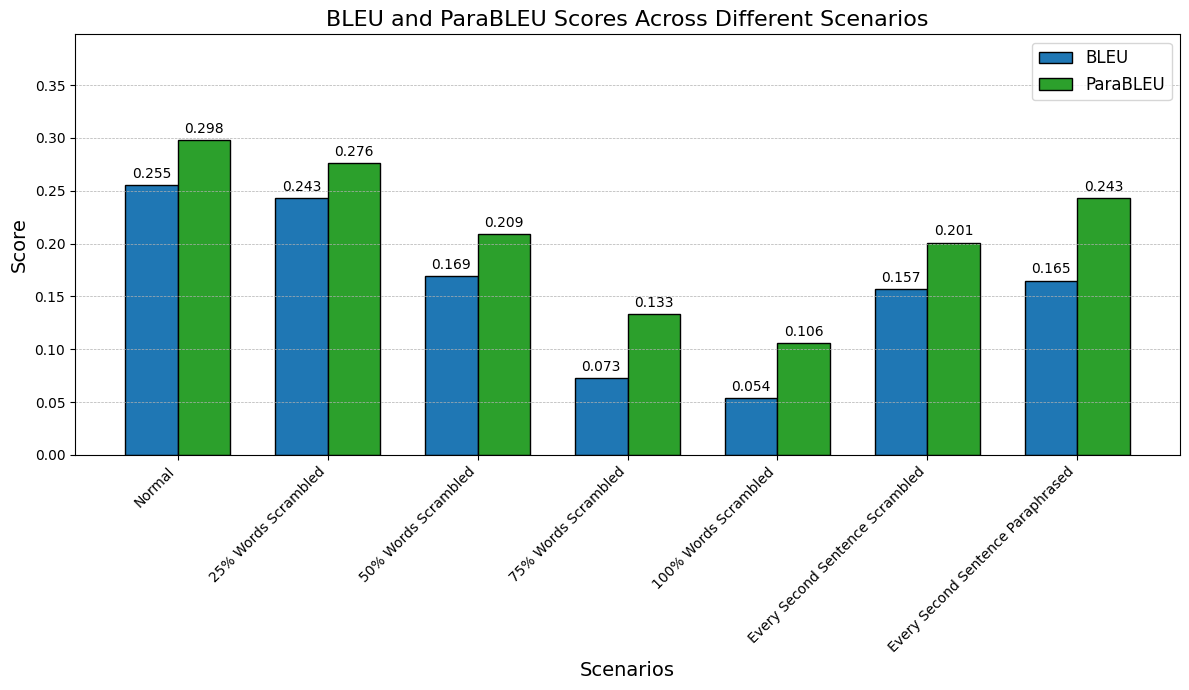

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data
scenario_names = [
    "Normal",
    "25% Words Scrambled",
    "50% Words Scrambled",
    "75% Words Scrambled",
    "100% Words Scrambled",
    "Every Second Sentence Scrambled",
    "Every Second Sentence Paraphrased"
]

bleu_scores = [0.255, 0.243, 0.169, 0.073, 0.054, 0.157, 0.165]
parableu_scores = [0.298, 0.276, 0.209, 0.133, 0.106, 0.201, 0.243]

def plot_bleu_parableu(scenario_names, bleu_scores, parableu_scores):
    x = np.arange(len(scenario_names))
    width = 0.35  # Width of the bars

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot BLEU and ParaBLEU bars
    rects1 = ax.bar(
        x - width / 2,
        bleu_scores,
        width,
        label="BLEU",
        color="#1f77b4",
        edgecolor='black'
    )
    rects2 = ax.bar(
        x + width / 2,
        parableu_scores,
        width,
        label="ParaBLEU",
        color="#2ca02c",
        edgecolor='black'
    )

    # Add text labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel("Scenarios", fontsize=14)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_title("BLEU and ParaBLEU Scores Across Different Scenarios", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(scenario_names, rotation=45, ha="right")
    ax.set_ylim(0, max(max(bleu_scores), max(parableu_scores)) + 0.1)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    # Annotate bars with their heights
    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Offset text by 3 points vertically
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=10
            )

    plt.tight_layout()
    plt.show()

plot_bleu_parableu(scenario_names, bleu_scores, parableu_scores)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
scenario_names = [
    "Normal",
    "25% Words Scrambled",
    "50% Words Scrambled",
    "75% Words Scrambled",
    "100% Words Scrambled",
    "Every Second Sentence Scrambled",
    "Every Second Sentence Paraphrased"
]

bleu_scores = [0.255, 0.243, 0.169, 0.073, 0.054, 0.157, 0.165]
parableu_scores = [0.298, 0.276, 0.209, 0.133, 0.106, 0.201, 0.243]
wer_scores = [0.612, 0.621, 0.689, 0.754, 0.792, 0.705, None]  # WER for the last scenario is missing

def plot_bleu_parableu(scenario_names, bleu_scores, parableu_scores):
    x = np.arange(len(scenario_names))
    width = 0.35  # Width of the bars

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot BLEU and ParaBLEU bars
    rects1 = ax.bar(
        x - width / 2,
        bleu_scores,
        width,
        label="BLEU",
        color="#1f77b4",
        edgecolor='black'
    )
    rects2 = ax.bar(
        x + width / 2,
        parableu_scores,
        width,
        label="ParaBLEU",
        color="#2ca02c",
        edgecolor='black'
    )

    # Add text labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel("Scenarios", fontsize=14)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_title("BLEU and ParaBLEU Scores Across Different Scenarios", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(scenario_names, rotation=45, ha="right")
    ax.set_ylim(0, max(max(bleu_scores), max(parableu_scores)) + 0.1)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    # Annotate bars with their heights
    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Offset text by 3 points vertically
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=10
            )

    plt.tight_layout()
    plt.show()

def plot_wer(scenario_names, wer_scores):
    x = np.arange(len(scenario_names))

    # Handle missing WER data by replacing None with np.nan
    wer_scores = [score if score is not None else np.nan for score in wer_scores]

    plt.figure(figsize=(12, 7))
    bars = plt.bar(
        x,
        wer_scores,
        width=0.5,
        color="#d62728",
        edgecolor='black'
    )
    plt.xlabel("Scenarios", fontsize=14)
    plt.ylabel("WER", fontsize=14)
    plt.title("WER Across Different Scenarios", fontsize=16)
    plt.xticks(x, scenario_names, rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)

    # Annotate bars with their heights
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if not np.isnan(height):
            plt.annotate(
                f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=10
            )
        else:
            plt.annotate(
                'N/A',
                xy=(bar.get_x() + bar.get_width() / 2, plt.ylim()[1] * 0.05),
                xytext=(0, 0),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=10,
                color='red'
            )

    plt.tight_layout()
    plt.show()

plot_bleu_parableu(scenario_names, bleu_scores, parableu_scores)
plot_wer(scenario_names, wer_scores)
